# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.5 which is incompatible.


In [2]:
# from unityagents import UnityEnvironment
# import numpy as np

# env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# # get the default brain
# brain_name = env.brain_names[0]
# brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In [4]:
# # reset the environment
# env_info = env.reset(train_mode=True)[brain_name]

# # number of agents
# num_agents = len(env_info.agents)
# print('Number of agents:', num_agents)

# # size of each action
# action_size = brain.vector_action_space_size
# print('Size of each action:', action_size)

# # examine the state space 
# states = env_info.vector_observations
# state_size = states.shape[1]
# print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
# print('The state for the first agent looks like:', states[0])

### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [5]:
# env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
# states = env_info.vector_observations                  # get the current state (for each agent)
# scores = np.zeros(num_agents)                          # initialize the score (for each agent)
# while True:
#     actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
#     actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
#     env_info = env.step(actions)[brain_name]           # send all actions to tne environment
#     next_states = env_info.vector_observations         # get next state (for each agent)
#     rewards = env_info.rewards                         # get reward (for each agent)
#     dones = env_info.local_done                        # see if episode finished
#     scores += env_info.rewards                         # update the score (for each agent)
#     states = next_states                               # roll over states to next time step
#     if np.any(dones):                                  # exit loop if episode finished
#         break
# print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

### 4. Define the actor and critic models

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from unityagents import UnityEnvironment

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return -lim, lim


class Actor(nn.Module):
    def __init__(self, state_size, action_size, fc1_units, fc2_units):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.bn1 = nn.BatchNorm1d(fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.bn2 = nn.BatchNorm1d(fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        if state.dim() == 1:
            state = torch.unsqueeze(state, 0)

        x = self.bn1(F.relu(self.fc1(state)))
        x = self.bn2(F.relu(self.fc2(x)))
        return F.tanh(self.fc3(x))


class Critic(nn.Module):
    def __init__(self, state_size, action_size, fc1_units, fc2_units):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.bn1 = nn.BatchNorm1d(fc1_units)
        self.fc2 = nn.Linear(fc1_units + action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        if state.dim() == 1:
            state = torch.unsqueeze(state, 0)

        x = self.bn1(F.relu(self.fc1(state)))
        x = F.relu(self.fc2(torch.cat((x, action), dim=1)))
        return self.fc3(x)

### 5. Define the agent and supporting classes

In [7]:
# from collections import namedtuple
# Experience = namedtuple('Experience', 'state full_state action reward next_state full_next_state done')

# class Replay:
#     def __init__(self, action_size, buffer_size, batch_size):
#         self.action_size = action_size
#         self.buffer = deque(maxlen=buffer_size)
#         self.batch_size = batch_size

#     def add(self, state, full_state, action, reward, next_state, full_next_state, done):
#         experience = Experience(state, full_state, action, reward, next_state, full_next_state, done)
#         self.buffer.append(experience)

#     def sample(self):
#         experiences = random.sample(self.buffer, k=self.batch_size)

#         states = torch.from_numpy(np.vstack([e.state for e in experiences])).float().to(DEVICE)
#         full_states = torch.from_numpy(np.vstack([e.full_state for e in experiences])).float().to(DEVICE)
#         actions = torch.from_numpy(np.vstack([e.action for e in experiences])).float().to(DEVICE)
#         rewards = torch.from_numpy(np.vstack([e.reward for e in experiences])).float().to(DEVICE)
#         next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences])).float().to(DEVICE)
#         full_next_states = torch.from_numpy(np.vstack([e.full_next_state for e in experiences])).float().to(DEVICE)
#         dones = torch.from_numpy(np.vstack([e.done for e in experiences]).astype(np.uint8)).float().to(DEVICE)

#         return states, full_states, actions, rewards, next_states, full_next_states, dones

#     def __len__(self):
#         return len(self.buffer)

class Replay:
    def __init__(self, action_size, buffer_size, batch_size):
        self.action_size = action_size
        self.buffer = deque(maxlen=buffer_size)
        self.batch_size = batch_size

    def add(self, transition):
        self.buffer.append(transition)

    def sample(self):
        return random.sample(self.buffer, k=self.batch_size)

    def __len__(self):
        return len(self.buffer)


def transpose_to_tensor(tuples):
    def to_tensor(x):
        return torch.tensor(x, dtype=torch.float).to(DEVICE)

    return list(map(to_tensor, zip(*tuples)))


class Agent:
    def __init__(self, config):
        self.config = config

        self.online_actor = config.actor_fn().to(DEVICE)
        self.target_actor = config.actor_fn().to(DEVICE)
        self.actor_opt = config.actor_opt_fn(self.online_actor.parameters())

        self.online_critic = config.critic_fn().to(DEVICE)
        self.target_critic = config.critic_fn().to(DEVICE)
        self.critic_opt = config.critic_opt_fn(self.online_critic.parameters())

        self.noises = [config.noise_fn() for _ in range(config.num_agents)]
        self.replay = config.replay_fn()

    def step(self, states, actions, rewards, next_states, dones):
        full_state = states.flatten()
        next_full_state = next_states.flatten()
        self.replay.add((states, full_state, actions, rewards, next_states, next_full_state, dones))
        #self.replay.add(states,full_state, actions, rewards, next_states,next_full_state, dones)

        if len(self.replay) > self.replay.batch_size:
            self.learn()

    def act(self, state, add_noise=True):
        state = torch.from_numpy(state).float().to(DEVICE)

        self.online_actor.eval()

        with torch.no_grad():
            action = self.online_actor(state).cpu().data.numpy()

        self.online_actor.train()

        if add_noise:
            action += [n.sample() for n in self.noises]
        
        return np.clip(action, -1, 1)

    def reset(self):
        [n.reset() for n in self.noises]

    def learn(self):
        #states, full_states, actions, rewards, next_states, full_next_states, dones = self.replay.sample()

        transitions = self.replay.sample()
        states, full_state, actions, rewards, next_states, next_full_state, dones = transpose_to_tensor(transitions)
                                                                                                        
        #print('Shapes of states:',np.shape(states))
        #print('Shapes of full states:',np.shape(full_states))
        #print('Shapes of rewards:',np.shape(rewards))
        
        # Update online critic mode
        
        # Compute actions for next states with the target actor model
        with torch.no_grad():
            target_next_actions = [self.target_actor(next_states[:,i, :]) for i in range(self.config.num_agents)]

        target_next_actions = torch.cat(target_next_actions, dim=1)

        # Compute Q values for the next states and actions with the target critic model
        with torch.no_grad():
            target_next_qs = self.target_critic(next_full_state.to(DEVICE), target_next_actions.to(DEVICE))
            
            
        # Compute target Q values for the current states using the Bellman equation
        target_qs = rewards.sum(1, keepdim=True)
        target_qs += self.config.discount * target_next_qs * (1 - dones.max(1, keepdim=True)[0])
        
        # Compute Q values for the current states and actions with the online critic model
        actions = actions.view(actions.shape[0], -1)
        online_qs = self.online_critic(full_state.to(DEVICE), actions.to(DEVICE))
        
        # Compute and minimize the online critic loss
        critic_loss = F.mse_loss(online_qs, target_qs)
        self.critic_opt.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.online_critic.parameters(), 1)
        self.critic_opt.step()

        # Update online actor model
        # Predict actions for current states from the online actor model
        online_actions = [self.online_actor(states[:, i, :]) for i in range(self.config.num_agents)]
        online_actions = torch.cat(online_actions, dim=1)
        
        
        # Compute and minimize the online actor loss
        online_actor_loss = -self.online_critic(full_state.to(DEVICE), online_actions.to(DEVICE)).mean()
        self.actor_opt.zero_grad()
        online_actor_loss.backward()
        self.actor_opt.step()

        # Update target critic and actor models
        self.soft_update(self.online_critic, self.target_critic)
        self.soft_update(self.online_actor, self.target_actor)

    def soft_update(self, online_model, target_model):
        for target_param, online_param in zip(target_model.parameters(), online_model.parameters()):
            target_param.data.copy_(self.config.target_mix * online_param.data + (1.0 - self.config.target_mix) * target_param.data)


class OrnsteinUhlenbeck:
    def __init__(self, size, mu, theta, sigma):
        self.state = None
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.reset()

    def reset(self):
        self.state = copy.copy(self.mu)

    def sample(self):
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for _ in range(len(x))])
        self.state = x + dx
        return self.state


### 6. Define the coniguration and hyper parameters

In [8]:
import random
import copy
from collections import deque

import numpy as np
import matplotlib.pyplot as plt

class Config:
    def __init__(self, seed):
        self.seed = seed
        random.seed(seed)
        torch.manual_seed(seed)

        self.env = None
        self.brain_name = None
        self.state_size = None
        self.num_agents = None
        self.action_size = None
        self.actor_fn = None
        self.actor_opt_fn = None
        self.critic_fn = None
        self.critic_opt_fn = None
        self.replay_fn = None
        self.noise_fn = None
        
        self.buffer_size = None
        self.batch_size  = None
 
        self.discount = None
        self.target_mix = None

        self.lr_actor  = None
        self.lr_critic = None
    
        self.noise_mu = None
        self.noise_theta = None
        self.noise_sigma = None
    
        self.actor_fc1 = None
        self.actor_fc2 = None
        self.critic_fc1 = None
        self.critic_fc2 = None
    
        self.discount = None
        self.target_mix = None

        self.max_episodes = None
        self.max_steps = None

        self.actor_path = None
        self.critic_path = None
        self.scores_path = None
        
        self.print_every = None

def ddpg(agent):
    config = agent.config
    scores_deque = deque(maxlen=100)
    scores = []

    for episode in range(1, config.max_episodes + 1):
        agent.reset()
        score = np.zeros(config.num_agents)
        
        env_info = config.env.reset(train_mode=True)[config.brain_name]
        states = env_info.vector_observations

        for step in range(config.max_steps):
            
            actions = agent.act(states)
            env_info = config.env.step(actions)[config.brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done

            agent.step(states, actions, rewards, next_states, dones)

            score += rewards
            states = next_states

            if np.any(dones):
                break

        score = score.max()        
        scores.append(score)
        scores_deque.append(score)
        mean_score = np.mean(scores_deque)

        print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f}'.format(episode, mean_score, score),end="")

        if episode % config.print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f}'.format(episode, mean_score, score))
            torch.save(agent.online_actor.state_dict(), config.actor_path)
            torch.save(agent.online_critic.state_dict(), config.critic_path)
    
        if mean_score >= config.goal_score:
            print('\rEnvironment solved in {} episodes!!'.format(episode-100))
            print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f}'.format(episode, mean_score, score))
            torch.save(agent.online_actor.state_dict(), config.actor_path)
            torch.save(agent.online_critic.state_dict(), config.critic_path)
        
            break

    torch.save(agent.online_actor.state_dict(), config.actor_path)
    torch.save(agent.online_critic.state_dict(), config.critic_path)

    fig, ax = plt.subplots()
    ax.plot(np.arange(1, len(scores) + 1), scores)
    ax.set_ylabel('Score')
    ax.set_xlabel('Episode #')
    fig.savefig(config.scores_path)
    plt.show()




### 7. Train the Agent with DDPG (Deep Deterministic Policy Gradient)


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Episode 100	Average Score: 0.00	Score: 0.00
Episode 200	Average Score: 0.00	Score: 0.00
Episode 300	Average Score: 0.00	Score: 0.00
Episode 400	Average Score: 0.00	Score: 0.00
Episode 500	Average Score: 0.01	Score: 0.00
Episode 600	Average Score: 0.00	Score: 0.00
Episode 700	Average Score: 0.03	Score: 0.00
Episode 800	Average Score: 0.53	Score: 2.60
Environment solved in 729 episodes!!e: 0.90
Episode 829	Average Score: 1.00	Score: 0.90


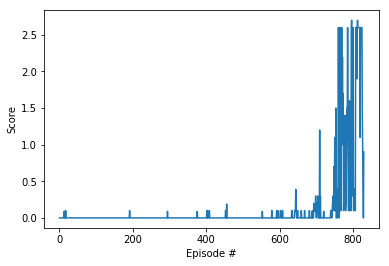

In [9]:
from unityagents import UnityEnvironment
import numpy as np

def run():
    config = Config(seed=6)
 
    config.buffer_size = int(1e6)
    config.batch_size  = int(128)
 
    config.discount = 0.99
    config.target_mix = 3e-3

    config.lr_actor  = 1e-3
    config.lr_critic = 1e-3
    
    config.noise_mu = 0.
    config.noise_theta = 0.15
    config.noise_sigma = 0.1
    
    config.actor_fc1 = 128
    config.actor_fc2 = 128
    config.critic_fc1 = 128
    config.critic_fc2 = 128
    
    config.max_episodes = int(2000)
    config.max_steps = int(1e6)
    config.goal_score = 1

    config.print_every = 100
    config.actor_path = 'actor.pth'
    config.critic_path = 'critic.pth'
    config.scores_path = 'scores.png'
    
    config.env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")
    config.brain_name = config.env.brain_names[0]
    env_info = config.env.reset(train_mode=True)[config.brain_name]

    config.num_agents = len(env_info.agents)
    config.state_size = env_info.vector_observations.shape[1]
    config.action_size = config.env.brains[config.brain_name].vector_action_space_size

    config.actor_fn = lambda: Actor(config.state_size, config.action_size, fc1_units=config.actor_fc1, fc2_units=config.actor_fc2)
    config.actor_opt_fn = lambda params: optim.Adam(params, lr=config.lr_actor)

    config.critic_fn = lambda: Critic(config.state_size * config.num_agents, config.action_size * config.num_agents, fc1_units=config.critic_fc1, fc2_units=config.critic_fc2)
    config.critic_opt_fn = lambda params: optim.Adam(params, lr=config.lr_critic)

    config.replay_fn = lambda: Replay(config.action_size, buffer_size=config.buffer_size, batch_size=config.batch_size)
    config.noise_fn = lambda: OrnsteinUhlenbeck(config.action_size, mu=config.noise_mu, theta=config.noise_theta, sigma=config.noise_sigma)

    agent = Agent(config)
    ddpg(agent)
    
run()


### 8. Close the Environment

In [ ]:
env.close()